In [1]:
import torch
from binNF.normalizing_flows.manager import *
import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing as mp


In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def g(x): #box: expect 0.25 in dim2
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q<0.5,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2)) 

def camel(x):
    return torch.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+torch.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )

def gaussiannp(x):
    return np.exp( -(x[:,0])**2 )

def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

In [3]:
n_flow = 2      # number of dimensions


# We define our NormalizingFlow object 
NF =  PWLinManager(n_flow=n_flow)



In [4]:
#The model is created
NF.create_model(n_pass_through=1,n_cells=2, n_bins=25, NN=[10,10,10,10,10], roll_step=1)
optim = torch.optim.Adamax(NF._model.parameters(),lr=3e-4, weight_decay=1e-7) 


#sacred -> yoshi parameter search
#simpler, less nodes: 2d 25/5*10/3e-4 10000; 1d 10/3*10/0.1e-4 20000




#write a main execution script for terminal





In [5]:

history=NF._train_variance_forward_seq(camel,optim,"./logs/tmp/",9000,500,0,True, True,True)


Initial loss
tensor(0.1775, grad_fn=<MeanBackward0>)
Initial variance
tensor(0.3971, grad_fn=<VarBackward0>)
Epoch of best result
468
Best loss
tensor(0.0906, grad_fn=<MeanBackward0>)
Best variance
tensor(0.0499, grad_fn=<VarBackward0>)
Sequential(
  (0): PWLin(
    (NN): Sequential(
      (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1, out_features=10, bias=False)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=10, bias=False)
      (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Linear(in_features=10, out_features=10, bias=False)
      (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=False)
      (11): BatchNorm1d(10, eps=1e-05, momentu

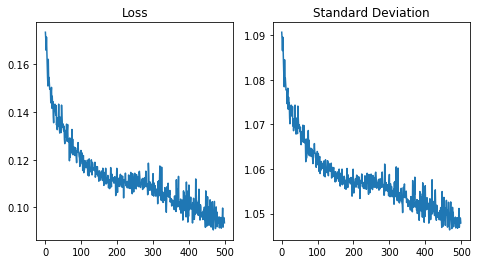

In [6]:

print('Initial loss')
print(NF.int_loss)
print('Initial variance')
print(NF.int_var)
print('Epoch of best result')
print(NF.best_epoch)
print('Best loss')
print(NF.best_loss)
print('Best variance')
print(NF.best_var)
      
print(NF.model)
losses=[]
for key, value in NF.history.items():
    losses.append(value["loss"])

fig = plt.figure(figsize=(12, 4))
a1=fig.add_subplot(131)
plt.plot(losses)

a1.title.set_text('Loss')
a2=fig.add_subplot(132)
plt.plot(np.sqrt(np.exp(losses)))
a2.title.set_text('Standard Deviation')






In [20]:

w = torch.empty(40, NF.n_flow)
torch.nn.init.uniform_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)

"""
f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))

"""

W
tensor([[0.9545, 0.6099],
        [0.5643, 0.0594],
        [0.7099, 0.4250],
        [0.2709, 0.9295],
        [0.6115, 0.2234],
        [0.2469, 0.4761],
        [0.7792, 0.3722],
        [0.2147, 0.3288],
        [0.1265, 0.6783],
        [0.8870, 0.0293],
        [0.6161, 0.7583],
        [0.5907, 0.3219],
        [0.7610, 0.7628],
        [0.6870, 0.4121],
        [0.3676, 0.5535],
        [0.4117, 0.3510],
        [0.8196, 0.9297],
        [0.4505, 0.3881],
        [0.5073, 0.4701],
        [0.6202, 0.6401],
        [0.0459, 0.3155],
        [0.9211, 0.6948],
        [0.4751, 0.1985],
        [0.1941, 0.0521],
        [0.3370, 0.6689],
        [0.8188, 0.7308],
        [0.0580, 0.1993],
        [0.4211, 0.9837],
        [0.5723, 0.3705],
        [0.7069, 0.3096],
        [0.1764, 0.8649],
        [0.2726, 0.3998],
        [0.0026, 0.8346],
        [0.8788, 0.6822],
        [0.1514, 0.0065],
        [0.0939, 0.8729],
        [0.7401, 0.9208],
        [0.7619, 0.6265],
        [0

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

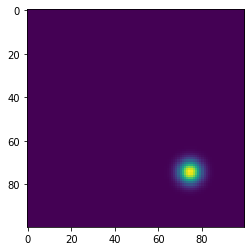

In [49]:
xs = np.linspace(-10,10,100)
ys = np.linspace(10,-10,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=gaussianbnp(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)
plt.imshow(zs)
plt.show()

In [22]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1,n_bins=10, nn_width=2, NN=[20,20,20], roll_step=0)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.6108, 0.7451],
        [0.3028, 0.2412],
        [0.2823, 0.1151],
        ...,
        [0.5725, 0.1838],
        [0.8225, 0.9309],
        [0.1988, 0.2423]], requires_grad=True)
with jacob
tensor([[0.6108, 0.7451, 1.0000],
        [0.3028, 0.2412, 1.0000],
        [0.2823, 0.1151, 1.0000],
        ...,
        [0.5725, 0.1838, 1.0000],
        [0.8225, 0.9309, 1.0000],
        [0.1988, 0.2423, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[0.6108, 0.7238, 0.7407],
        [0.3028, 0.2571, 1.1249],
        [0.2823, 0.1301, 1.1378],
        ...,
        [0.5725, 0.1827, 1.4329],
        [0.8225, 0.9263, 1.0666],
        [0.1988, 0.2883, 0.6346]], grad_fn=<CatBackward>)
X
tensor([[0.6108, 0.7238],
        [0.3028, 0.2571],
        [0.2823, 0.1301],
        ...,
        [0.5725, 0.1827],
        [0.8225, 0.9263],
        [0.1988, 0.2883]])
diff
tensor([-0.1342,  0.0616,  0.1672,  ...,  0.3886, -0.1084, -0.0435],
       grad_fn=<SubBackward0>)
f(x)
tensor([2.6622, 2.2543, 

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

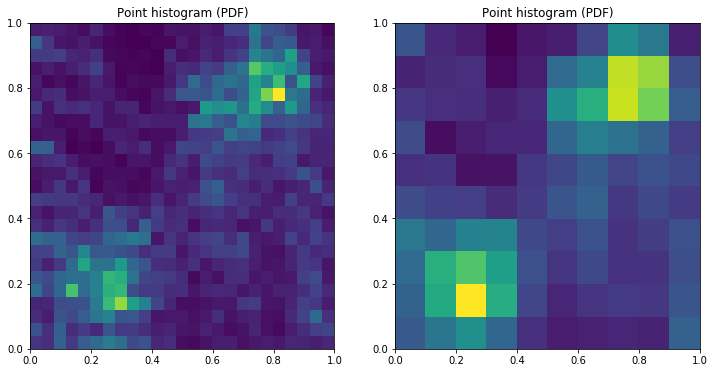

In [7]:
w = torch.empty((12100,2)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))


Y=NF.format_input(w)
X=NF.model(Y)
XX=NF.best_model(Y)
#Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
XX=XX.data.numpy()
#z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#fig = plt.figure(figsize=(6, 6))
a4=fig.add_subplot(122)
#plt.hist2d(X[:,0],X[:,1],bins=2500)
#Q=[[]]
#Q=[[-1,-1,-1],[2,2,2]]
#Q[:,1]=[,]
#Q=np.ones((10,2))
#Q[:,0]*=-1
plt.hist2d(XX[:,0],XX[:,1],bins=10)
axes = plt.gca()
axes.set_xlim([-0,1])
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)



In [48]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)

tensor([[ 124.0116,   47.9657],
        [  -7.4994, -213.4038],
        [  67.7636,  -32.0429],
        [ -42.4372,  -10.8968],
        [ -33.5290,    6.3961],
        [  13.0762,  -38.7510],
        [  83.4277,  -12.8562],
        [ -82.8009,  -22.0921],
        [  11.4701,  154.7312],
        [-127.1577,  -81.6875],
        [  43.4944,   21.7519],
        [ 182.8632,   95.6407],
        [-137.9283,  -93.3104],
        [  41.1783,  103.4374],
        [-113.1125,  -20.7664],
        [ 101.5151,   29.5386],
        [ -55.7257,   81.6997],
        [ -72.3741,   35.4625],
        [  25.8046,   -1.5254],
        [-172.8428,   73.4215]])